# "Drop Number One" analysis

This is a modification of the "Drop One Variable" analysis that drops the top-ranked observation(s) instead of the series of input variables. This analysis tests the leverage of the "most vulnerable" observation on the net contributions of input variables to SoVI as well as the changes in index rank among US counties. If the index is robust to the leverage of individual observations, we expect to see minimal reshuffling of variable influence/county ranks when the top-ranked observation is dropped.

In [1]:
import os
import pandas as pd
import pysal as ps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.mstats import zscore as ZSCORE
from scipy.stats import rankdata
from scipy.stats import spearmanr 

# sovi compute script
import sys
sys.path.append(os.path.join(os.getcwd(),'code'))
from spss_pca import SPSS_PCA
import compute_sovis

C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


did not pull supplementary ACS data - A


C:\Users\Joe\Anaconda3\lib\site-packages\pysal\weights\weights.py:189: UserWarning: There are 7 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
C:\Users\Joe\Anaconda3\lib\site-packages\pysal\weights\weights.py:190: UserWarning: Island ids: g02016, g15001, g15003, g15007, g25019, g36085, g53055
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


('WARNING: ', 'g02016', ' is an island (no neighbors)')
('WARNING: ', 'g15001', ' is an island (no neighbors)')
('WARNING: ', 'g15003', ' is an island (no neighbors)')
('WARNING: ', 'g15007', ' is an island (no neighbors)')
('WARNING: ', 'g25019', ' is an island (no neighbors)')
('WARNING: ', 'g36085', ' is an island (no neighbors)')
('WARNING: ', 'g53055', ' is an island (no neighbors)')


## Methods

#### Some prep: 

In [2]:
#Get attribute names
attr_names=[j[0] for j in compute_sovis.input_names]

(Some of the stuff in the cell below might be removable. I just kept it all for now to make sure everything was in place for running SoVI...)

In [3]:
# rather than populating the `netContrib` object
# we can just use the final var contributions from 
# `compute_sovis`...
netContrib=compute_sovis.variable_contributions

#reorder table        
cols = ['USA', 'FEMA_1', 'g23g33g25', 
'FEMA_2', 'g36','FEMA_3', 'g51', 'FEMA_4', 'g13', 'FEMA_5', 'g17',
'FEMA_6', 'g48', 'FEMA_7', 'g29', 'FEMA_8', 'g46', 'FEMA_9', 'g06', 'FEMA_10', 
'g16']
netContrib = netContrib[cols]

#variable rank using absolute value      
rankContrib = abs(netContrib).apply(rankdata, axis=0, method='average')
rankContrib = (28-rankContrib) + 1

combContrib = pd.DataFrame(columns=list(netContrib.columns), index=list(netContrib.index))
#can't think of a more elegant way to do this
for aRow in range(netContrib.shape[1]):
    for aCol in range(netContrib.shape[0]):
        combContrib.ix[aCol][aRow] = str(round(netContrib.ix[aCol][aRow], 2)) + ' (' + str(int(rankContrib.ix[aCol][aRow])) + ')'

#build list of varIDs and human readable names
#sort and use as index for conContrib
nameSort = [[name, hrname] for name, sign, sample, hrname in compute_sovis.input_names]
nameSort = pd.DataFrame(nameSort)
nameSort.index = nameSort.loc[:,0]
nameSort = nameSort.reindex(list(combContrib.index))    
    
#set descriptive names
combContrib.index = list(nameSort.loc[:,1])

# # write out results
# combContrib

I found an issue with the computed SoVI ranks. The SoVI score (`sovi`) is added to `compute_sovis.US_Sovi_Score` as a generic "object" which messes up the ranking. Therefore it is necessary to re-rank SoVI:

In [4]:
## convert sovi score to float
# compute_sovis.US_Sovi_Score.sovi=compute_sovis.US_Sovi_Score.sovi.astype('float64')

In [5]:
## re-rank sovi
# compute_sovis.US_Sovi_Score['rank']=compute_sovis.US_Sovi_Score.sovi.rank(ascending=False)

Confirm that re-ranking worked, using previous results from 2014. Now there should be no difference in ranks following the conversion of the new run's SoVI to `float64`:

In [6]:
# sovi_old=pd.read_csv('data/check/SoVI_USA_all.csv')
# sovi_old['rank']=sovi_old.sovi.rank(ascending=False)

# sovi_orig=compute_sovis.US_Sovi_Score.copy()
# sovi_orig['Geo_FIPS']=sovi_orig.index
# sovi_compare=pd.merge(sovi_old,sovi_orig,on='Geo_FIPS')

# (sovi_compare.rank_x-sovi_compare.rank_y).describe()

Get the index of the "most vulnerable" county in the USA according to SoVI (Bronx, NY), and generate a version of the SoVI inputs with it dropped:

In [7]:
# get the index of the 
# "most vulnerable" county in USA
sovi_no1=compute_sovis.US_Sovi_Score[compute_sovis.US_Sovi_Score['rank']==compute_sovis.US_Sovi_Score['rank'].min()].index

In [8]:
# the data without Bronx
US_drop_no1=compute_sovis.US_All.drop(sovi_no1)

Preserve the original net contribution and county ranks. These will be used to compute changes in net contribution/county rank once SoVI is recomputed:

In [9]:
# These are still needed for computing change in rank...

#Construct table to hold the results of the drop one analysis
#Sort variable list based on importance rank.
USvarRanks = rankContrib.USA.copy() #have to make a copy to sort index
USvarRanks.sort('USA')
# dropLevels = USvarRanks.index

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [10]:
# preserve the original county ranks
# also for computing change in rank...
orig_rank=compute_sovis.US_Sovi_Score.drop(sovi_no1)['rank']

#### Now let's recompute SoVI with Bronx, NY dropped:

In [11]:
# preserve GEOIDs as an index
# for computed SoVI
geoLevels=US_drop_no1.Geo_FIPS

#Compute drop "number one"
pca = SPSS_PCA(US_drop_no1.drop(['Geo_FIPS', 'stateID'], axis = 1, inplace = False), reduce=True, varimax=True)
sovi_actual = pca.scores_rot.sum(1)
sovi_actual = pd.DataFrame(sovi_actual, index=geoLevels, columns=['sovi'])
US_SoVI_Drop1_Score = sovi_actual.values # SoVI score

In [12]:
# add SoVI ranks for run
# any way to clean this up?
US_SoVI_Drop1_Rank = pd.Series([i[0] for i in sovi_actual.values],index=geoLevels).rank(ascending=False)

In [13]:
# check indices match
sum(US_SoVI_Drop1_Rank.index==orig_rank.index)

3142

Recompute net variable contribution:

In [14]:
attrib_contribution = pd.Series(data=pca.weights_rot.sum(1), index=US_drop_no1.columns.drop(['Geo_FIPS', 'stateID']))
#print(j +" " + str(np.isnan(attrib_contribution.values).sum()))
attrib_contribution = attrib_contribution.transpose()

# attrib_contribution.index = [j]
#print(attrib_contribution.loc[j,:])
US_Drop1_NetContrib = attrib_contribution #.values
US_Drop1_NetContrib=US_Drop1_NetContrib.rank(ascending=False)
US_Drop1_NetContrib=US_Drop1_NetContrib.convert_objects(convert_numeric=True)
US_Drop1_NetContrib = US_Drop1_NetContrib.apply(lambda x: np.round(x, 2))

US_Drop1_NetContrib=US_Drop1_NetContrib[USvarRanks.index] # sort values by original index ranking

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


### Results

#### Net Contribution
Lots of small movements, and some larger ones for Percent African-American (`QBLACK_ACS`) and Percent of Housing in Mobile Homes (`QMOHO`), whose values drop considerably (-11 and -18, respectively).

In [15]:
nc_chg_dropno1=pd.DataFrame({'orig_rank':USvarRanks,'dropno1_rank':US_Drop1_NetContrib})
nc_chg_dropno1['rank_chg']=nc_chg_dropno1.orig_rank-nc_chg_dropno1.dropno1_rank
nc_chg_dropno1

,dropno1_rank,orig_rank,rank_chg
QAGEDEP_ACS,1.0,1.0,0.0
QFEMALE_ACS,2.0,2.0,0.0
QSERV_ALT,3.0,3.0,0.0
QHISP_ACS,4.0,4.0,0.0
QFEMLBR,5.0,5.0,0.0
QNATAM_ACS,6.0,6.0,0.0
QESL_ALT,7.0,7.0,0.0
QSSBEN,8.0,8.0,0.0
QNOAUTO_ALT,9.0,9.0,0.0
QMOHO,28.0,10.0,-18.0


#### County Rank Change
County ranks appear fairly stable when Bronx, NY is left out of the data. The histogram is centered on near-zero movement, with some left skew (some counties dropping upwards of 150 places).

In [16]:
obs_rchg_drop1=pd.DataFrame({'orig_rank':orig_rank,'dropno1_rank':US_SoVI_Drop1_Rank},index=orig_rank.index)
obs_rchg_drop1['rank_chg']=obs_rchg_drop1.orig_rank-obs_rchg_drop1.dropno1_rank

C:\Users\Joe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


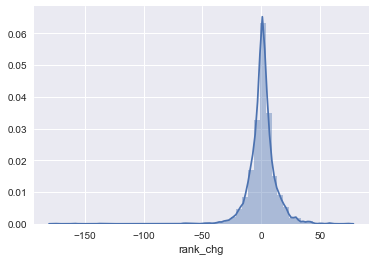

In [17]:
sns.distplot(obs_rchg_drop1.rank_chg)

### Map of Rank Changes
Just a simple `GeoPandas` choropleth to start...

In [18]:
import geopandas as gpd
from matplotlib.pylab import rcParams
import pysal as ps
rcParams['figure.figsize'] = 18, 15

In [19]:
sovi_map=gpd.read_file('data/spatial/USA_Counties_500k.shp')

In [20]:
# remove alaska and hawaii
sovi_map=sovi_map[~sovi_map['geoFIPS'].str.contains('g02') & ~sovi_map['geoFIPS'].str.contains('g15')]

In [21]:
# join the rank changes
obs_rchg_drop1['geoFIPS']=obs_rchg_drop1.index
sovi_map=pd.merge(sovi_map,obs_rchg_drop1,on='geoFIPS')

It is necessary before mapping to convert `rank_chg` to integer so that negative movements plot.

In [22]:
sovi_map.rank_chg=sovi_map.rank_chg.astype('int')

Raw value breaks are not being plotted in order for `geoPandas`, bin the breaks instead to ensure correct plot order:

In [23]:
# generate breaks
bb=ps.Natural_Breaks(sovi_map.rank_chg,k=3)
breaks_unique=np.unique(bb.yb) # unique break levels

In [24]:
## some helper functions for mapping

def getLabels(inData,var,breaks,cl,inc=1):
    
    if cl==breaks.min(): # first entry
        return 'l'+str(cl)+' '+str(inData[var].ix[np.where(breaks==cl)].min())+" : "+str(inData[var].ix[np.where(breaks==cl)].max()) 
    else:
        return 'l'+str(cl)+' '+str(inData[var].ix[np.where(breaks==cl-1)].max()+inc)+" : "+str(inData[var].ix[np.where(breaks==cl)].max()) 


def mapLabels(inData,var,breaks,inc=1,lab=None):

    breaks_unique=np.unique(breaks)
    
    if lab==None: # no custom labelling scheme set
        
        lab=[getLabels(inData,var,breaks,cl,inc) for cl in breaks_unique]
    
    # lookup table for class labels
    lab_lookup=pd.DataFrame({'break_class':breaks_unique,'label':lab})
    
    # the full set of labels
    lab_obs=[lab_lookup[lab_lookup['break_class']==i]['label'][i] for i in breaks]
    
    return lab_obs

Now plot using the binned labels...

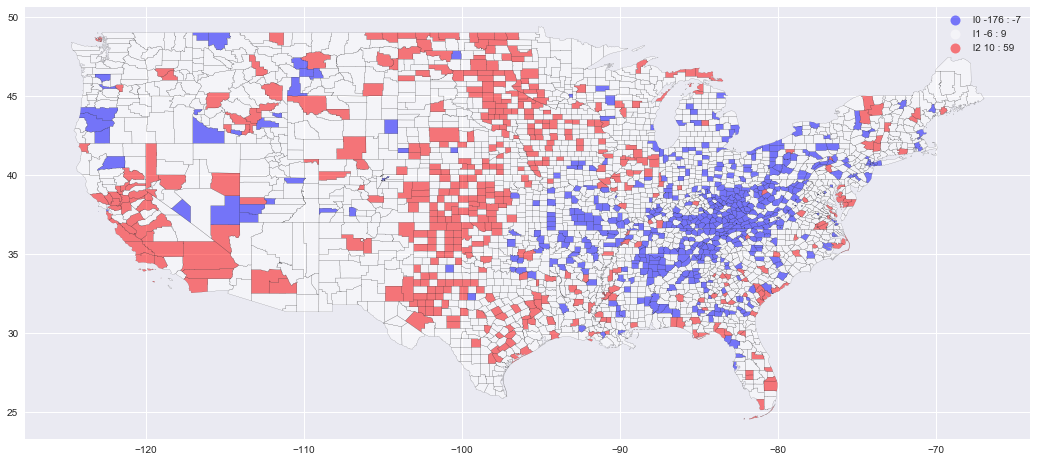

In [25]:
sovi_map['label']=mapLabels(sovi_map,'rank_chg',bb.yb)
sovi_map.plot(column='label',cmap='bwr',linewidth=0.1,legend=True)

When Bronx, NY is dropped, many counties around Ohio appear to drop in SoVI rank, upwards of 176 places. Additionally, counties throughout the Midwest, Texas, and California increase in SoVI rank, upwards of 59 places. While the magnitude of these effects is not great, it is somewhat troubling that the removal of a single county has the potential to affect the rankings of a number of distal counties.

## Automate "Drop Number One"

In [26]:
## "Drop number one" as a function
# one option for sovi, another for netContrib (needs add!)

def dropNo1(inputs,scores,subset=None,netContrib=None,return_no1=False):
    
    """
    inputs, the input variables, i.e. compute_sovis.USA_All 
    
    scores, the SoVI outputs containing scores and ranks i.e. compute_sovis.USA_Sovi_Score
    
    subset: list of GEOIDs for subset (use for FEMA region or state)
    
    netContrib: i.e. compute_sovis.variable_ranks
    """
    
    if not subset is None:
        scores=scores[scores[scores.columns[len(scores.columns)-1]].astype('str').str.contains(subset)] # scores for region id
        inputs=inputs[inputs.index.isin(scores[scores.columns[len(scores.columns)-1]].index)] # inputs for subset 

    # get the index of the 
    # "most vulnerable" county
    sovi_no1=scores[scores['rank']==scores['rank'].min()].index
    
    if return_no1:
        return sovi_no1

    # the data without no 1
    drop_no1=inputs.drop(sovi_no1)

    # preserve GEOIDs as an index
    # for computed SoVI
    geoLevels=drop_no1.Geo_FIPS
    
    #Compute drop "number one"
    pca = SPSS_PCA(drop_no1.drop(['Geo_FIPS', 'stateID'], axis = 1, inplace = False), reduce=True, varimax=True)
    sovi_actual = pca.scores_rot.sum(1)
    sovi_actual = pd.DataFrame(sovi_actual, index=geoLevels, columns=['sovi'])
    dropno1_score = sovi_actual.values # SoVI score
    
    if netContrib is None: # no net contrib var's specified, compute county ranks
        
        # preserve the original county ranks
        # also for computing change in rank...
        orig_rank=scores.drop(sovi_no1)['rank']

        # add SoVI ranks for run
        # any way to clean this up?
        dropno1_rank = pd.Series([i[0] for i in sovi_actual.values],index=geoLevels).rank(ascending=False)
        
        obs_rchg_drop1=pd.DataFrame({'orig_rank':orig_rank,'dropno1_rank':dropno1_rank},index=orig_rank.index)
        obs_rchg_drop1=obs_rchg_drop1.apply(lambda x: x.astype('int'),axis=1) # ensure all ints
        obs_rchg_drop1['rank_chg']=obs_rchg_drop1.orig_rank-obs_rchg_drop1.dropno1_rank
        
        return obs_rchg_drop1

    else: # net contribution
        
        #variable rank using absolute value      
        rankContrib = abs(netContrib).apply(rankdata, axis=0, method='average')
        rankContrib = (28-rankContrib) + 1
        
        #Construct table to hold the results of the drop one analysis
        #Sort variable list based on importance rank.
        if not subset:
            varRanks = rankContrib['USA'].copy() #have to make a copy to sort index
            varRanks.sort('USA')
        else:
            varRanks = rankContrib[subset].copy() #have to make a copy to sort index
            varRanks.sort(subset)

        # recompute net contribution for drop no1
        Drop1_NetContrib = pd.Series(data=pca.weights_rot.sum(1), index=drop_no1.columns.drop(['Geo_FIPS', 'stateID']))
        Drop1_NetContrib = Drop1_NetContrib.transpose()
        Drop1_NetContrib=Drop1_NetContrib.convert_objects(convert_numeric=True)
        Drop1_NetContrib = Drop1_NetContrib.apply(lambda x: np.round(x, 2))
        Drop1_NetContrib = Drop1_NetContrib.rank(ascending=False)

        Drop1_NetContrib=Drop1_NetContrib[varRanks.index] # sort values by original index ranking
        
        nc_chg_dropno1=pd.DataFrame({'orig_rank':varRanks,'dropno1_rank':Drop1_NetContrib})
        nc_chg_dropno1=nc_chg_dropno1.apply(lambda x: x.astype('int'),axis=1) # ensure all ints
        nc_chg_dropno1['rank_chg']=nc_chg_dropno1.orig_rank-nc_chg_dropno1.dropno1_rank
        
        return nc_chg_dropno1

#### Examples of Usage

##### USA

In [27]:
# county ranks
dropNo1(inputs=compute_sovis.US_All,scores=compute_sovis.US_Sovi_Score).head()

,dropno1_rank,orig_rank,rank_chg
Geo_FIPS,,,
g01001,2839,2836,-3
g01003,2183,2189,6
g01005,1578,1585,7
g01007,2973,2970,-3
g01009,2470,2465,-5


In [28]:
# variable net contribution
dropNo1(inputs=compute_sovis.US_All,scores=compute_sovis.US_Sovi_Score,netContrib=compute_sovis.variable_contributions)

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:74: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,dropno1_rank,orig_rank,rank_chg
QAGEDEP_ACS,1,1,0
QFEMALE_ACS,2,2,0
QSERV_ALT,3,3,0
QHISP_ACS,4,4,0
QFEMLBR,5,5,0
QNATAM_ACS,6,6,0
QESL_ALT,7,7,0
QSSBEN,8,8,0
QNOAUTO_ALT,9,9,0
QMOHO,28,10,-18


##### FEMA Region

In [29]:
dropNo1(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_2')

,dropno1_rank,orig_rank,rank_chg
Geo_FIPS,,,
g34001,19,17,-2
g34003,75,78,3
g34005,64,67,3
g34007,47,57,10
g34009,6,7,1
g34011,44,31,-13
g34013,22,35,13
g34015,66,68,2
g34017,58,60,2


In [30]:
dropNo1(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_2',netContrib=compute_sovis.variable_contributions)

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:69: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:74: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,dropno1_rank,orig_rank,rank_chg
QNATAM_ACS,19,1,-18
QPUNIT_ACS,28,2,-26
QUNOCCHU_ACS,7,3,-4
QFEMLBR,1,4,3
QSERV_ALT,9,5,-4
POPDENS,5,6,1
QNOAUTO_ALT,4,7,3
QPOVTY,8,8,0
QFAM,3,9,6
QCVLUN,23,10,-13


##### State

In [31]:
dropNo1(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,subset='g36')

,dropno1_rank,orig_rank,rank_chg
Geo_FIPS,,,
g36001,24,23,-1
g36003,43,42,-1
g36007,11,15,4
g36009,31,35,4
g36011,33,34,1
g36013,7,10,3
g36015,3,5,2
g36017,16,13,-3
g36019,42,45,3


In [32]:
dropNo1(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,subset='g36',netContrib=compute_sovis.variable_contributions)

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:69: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:74: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,dropno1_rank,orig_rank,rank_chg
QAGEDEP_ACS,1,1,0
QNATAM_ACS,28,2,-26
QFAM,3,3,0
QNRRES_ACS,6,4,-2
QFEMALE_ACS,2,5,3
QFEMLBR,5,6,1
QPUNIT_ACS,25,7,-18
QSSBEN,7,8,1
MEDAGE_ACS,9,9,0
MDGRENT_ALT,11,10,-1


### Top-Ranked Counties

In [33]:
# df containing county names - no need for the geometries
county_names=pd.DataFrame(gpd.read_file('data/spatial/USA_Counties_500k.shp').ix[:,['geoFIPS','NAME']],dtype='str')

In [34]:
# compute drop no1 rank change
ustest=dropNo1(inputs=compute_sovis.US_All,scores=compute_sovis.US_Sovi_Score)

In [35]:
# helper function for building rank change tables

from scipy.stats import spearmanr

def rankChgTable(inputs,scores,obs_names,subset=None,top=5,cor=False):
    
    dropno1_result=dropNo1(inputs=inputs,scores=scores,subset=subset)
    
    # ensure GEOID column in place
    # assumes missing GEOID values stored in df index
    if not 'geoFIPS' in dropno1_result:
        dropno1_result['geoFIPS']=dropno1_result.index
        
#     if not subset is None:
#         obs_names=obs_names[obs_names.geoFIPS.isin(dropno1_result.geoFIPS)]
        
    # merge dropno1 results with obs names
    rctab=dropno1_result.merge(obs_names,on='geoFIPS')
    
    # print the spearman rank correlation if specified
    if cor:
        spearcor=spearmanr(rctab.dropno1_rank,rctab.orig_rank)
        print("Spearman Rank Correlation: "+str(np.round(spearcor[0],5)),"\np-value: "+str(np.round(spearcor[1],4)))
        
    # get the dropped "number one" observation
    if subset is None:
        no1=obs_names[~obs_names.geoFIPS.isin(dropno1_result.geoFIPS)]
    else:
        no1=obs_names[obs_names.geoFIPS==dropNo1(inputs=inputs,scores=scores,subset=subset,return_no1=True)[0]]
    no1['orig_rank']=1
    
    # assemble table for original ranks
    orrk=rctab[rctab.orig_rank<=top].ix[:,['geoFIPS','orig_rank','NAME']].sort_values('orig_rank')
    orrk=no1.append(orrk)
    orrk['Top_Orig']=orrk.NAME+" ("+orrk.orig_rank.astype('int').astype('str')+")"
    orrk.index=[i+1 for i in range(0,top)]
    orrk.ix[:,['NAME','Top_Orig']]
    
    # assemble table for dropno1 ranks
    d1rk=rctab[rctab.dropno1_rank<=top].ix[:,['geoFIPS','dropno1_rank','orig_rank','NAME']].sort_values('dropno1_rank')
    d1rk['Top_DropNo1']=d1rk.NAME+" ("+d1rk.orig_rank.astype('int').astype('str')+")"
    d1rk.index=[i+1 for i in range(0,top)]
    d1rk.ix[:,['NAME','Top_DropNo1']]
    
    # return the tables combined
    return pd.DataFrame({'All_Counties':orrk.Top_Orig,'Drop_1':d1rk.Top_DropNo1})

##### Full US

In [36]:
# Full US
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.US_Sovi_Score,obs_names=county_names,top=10,cor=True)

Spearman Rank Correlation: 0.99991 
p-value: 0.0


,All_Counties,Drop_1
1,Bronx (1),Brooks (2)
2,Brooks (2),Starr (3)
3,Starr (3),Wade Hampton (4)
4,Wade Hampton (4),Shannon (5)
5,Shannon (5),Zavala (6)
6,Zavala (6),Menominee (7)
7,Menominee (7),Sioux (8)
8,Sioux (8),Todd (9)
9,Todd (9),Maverick (11)
10,Kings (10),Dimmit (12)


##### FEMA Regions

In [37]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_2',top=10,cor=True)

Spearman Rank Correlation: 0.89795 
p-value: 0.0


,All_Counties,Drop_1
1,Franklin (1),Bronx (4)
2,Hamilton (2),New York (3)
3,New York (3),Hamilton (2)
4,Bronx (4),Kings (5)
5,Kings (5),Fulton (8)
6,Cattaraugus (6),Cape May (7)
7,Cape May (7),Chemung (14)
8,Fulton (8),Otsego (15)
9,Essex (9),Delaware (12)
10,Greene (10),Erie (24)


In [38]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_3',top=10,cor=True)

Spearman Rank Correlation: 0.77761 
p-value: 0.0


,All_Counties,Drop_1
1,Forest (1),Emporia (2)
2,Emporia (2),Galax (3)
3,Galax (3),Martinsville (22)
4,Manassas Park (4),Lancaster (12)
5,Petersburg (5),Bedford (41)
6,Brunswick (6),Danville (28)
7,Greensville (7),Franklin (27)
8,Philadelphia (8),Petersburg (5)
9,Sussex (9),McDowell (17)
10,Sullivan (10),Baltimore (30)


In [39]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_4',top=10,cor=True)

Spearman Rank Correlation: 0.99825 
p-value: 0.0


,All_Counties,Drop_1
1,Robeson (1),Swain (2)
2,Swain (2),Glades (4)
3,Lake (3),Neshoba (8)
4,Glades (4),Lake (3)
5,Miami-Dade (5),Miami-Dade (5)
6,Telfair (6),Jackson (11)
7,Clay (7),Telfair (6)
8,Neshoba (8),Hendry (9)
9,Hendry (9),Clay (7)
10,DeSoto (10),DeSoto (10)


In [40]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_5',top=10,cor=True)

Spearman Rank Correlation: 0.98924 
p-value: 0.0


,All_Counties,Drop_1
1,Menominee (1),Mahnomen (2)
2,Mahnomen (2),Cook (3)
3,Cook (3),Holmes (4)
4,Holmes (4),Milwaukee (5)
5,Milwaukee (5),Sawyer (10)
6,Nobles (6),Mackinac (11)
7,Alexander (7),LaGrange (8)
8,LaGrange (8),Alexander (7)
9,Wayne (9),Wayne (9)
10,Sawyer (10),Nobles (6)


In [41]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_6',top=10,cor=True)

Spearman Rank Correlation: 0.99933 
p-value: 0.0


,All_Counties,Drop_1
1,Brooks (1),Starr (3)
2,McKinley (2),McKinley (2)
3,Starr (3),Foard (4)
4,Foard (4),Zavala (5)
5,Zavala (5),Cibola (6)
6,Cibola (6),Maverick (7)
7,Maverick (7),Cameron (8)
8,Cameron (8),Cottle (9)
9,Cottle (9),Culberson (10)
10,Culberson (10),Menard (11)


In [42]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_7',top=10,cor=True)

Spearman Rank Correlation: 0.97991 
p-value: 0.0


,All_Counties,Drop_1
1,Thurston (1),Brown (9)
2,Pemiscot (2),Pemiscot (2)
3,St. Louis (3),Seward (7)
4,Dunklin (4),St. Louis (3)
5,Wyandotte (5),Dakota (8)
6,New Madrid (6),Sheridan (31)
7,Seward (7),Dunklin (4)
8,Dakota (8),Wyandotte (5)
9,Brown (9),Knox (40)
10,Mississippi (10),New Madrid (6)


In [43]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_8',top=10,cor=True)

Spearman Rank Correlation: 0.72621 
p-value: 0.0


,All_Counties,Drop_1
1,Denver (1),Salt Lake (51)
2,Costilla (2),Arapahoe (23)
3,Huerfano (3),Otero (9)
4,Shannon (4),Adams (33)
5,Mineral (5),Pueblo (15)
6,Mineral (6),Costilla (2)
7,Liberty (7),Todd (21)
8,Piute (8),Shannon (4)
9,Otero (9),Broomfield (81)
10,Rio Grande (10),Conejos (11)


In [44]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_9',top=10,cor=True)

Spearman Rank Correlation: 0.97574 
p-value: 0.0


,All_Counties,Drop_1
1,Apache (1),Navajo (4)
2,San Francisco (2),Gila (3)
3,Gila (3),San Francisco (2)
4,Navajo (4),Imperial (5)
5,Imperial (5),Alpine (8)
6,Modoc (6),Modoc (6)
7,La Paz (7),Santa Cruz (9)
8,Alpine (8),La Paz (7)
9,Santa Cruz (9),Del Norte (10)
10,Del Norte (10),Mineral (11)


##### States

In [45]:
pd.unique(compute_sovis.State_Sovi_Score.state_id)

array(['g06', 'g13', 'g16', 'g17', 'g23g33g25', 'g29', 'g36', 'g46', 'g48',
       'g51'], dtype=object)

In [46]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g06',top=10,cor=True)

Spearman Rank Correlation: 0.99715 
p-value: 0.0


,All_Counties,Drop_1
1,Kings (1),Colusa (3)
2,San Francisco (2),Modoc (4)
3,Colusa (3),San Francisco (2)
4,Modoc (4),Lassen (5)
5,Lassen (5),Imperial (6)
6,Imperial (6),Madera (7)
7,Madera (7),Tulare (8)
8,Tulare (8),Monterey (9)
9,Monterey (9),Del Norte (10)
10,Del Norte (10),Glenn (11)


In [47]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g13',top=10,cor=True)

Spearman Rank Correlation: 0.99694 
p-value: 0.0


,All_Counties,Drop_1
1,Calhoun (1),Wheeler (4)
2,Stewart (2),Stewart (2)
3,Clay (3),Clay (3)
4,Wheeler (4),Telfair (5)
5,Telfair (5),Echols (6)
6,Echols (6),Hancock (9)
7,Randolph (7),Wilcox (8)
8,Wilcox (8),Randolph (7)
9,Hancock (9),Tattnall (11)
10,Atkinson (10),Atkinson (10)


In [48]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g36',top=10,cor=True)

Spearman Rank Correlation: 0.94818 
p-value: 0.0


,All_Counties,Drop_1
1,Bronx (1),Fulton (2)
2,Fulton (2),Montgomery (3)
3,Montgomery (3),Chemung (5)
4,Delaware (4),Oneida (8)
5,Chemung (5),Kings (19)
6,Columbia (6),Delaware (4)
7,Hamilton (7),Chautauqua (10)
8,Oneida (8),Erie (14)
9,Herkimer (9),Herkimer (9)
10,Chautauqua (10),Hamilton (7)


In [49]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g16',top=10,cor=True)

Spearman Rank Correlation: 0.99215 
p-value: 0.0


,All_Counties,Drop_1
1,Benewah (1),Owyhee (2)
2,Owyhee (2),Washington (3)
3,Washington (3),Elmore (5)
4,Canyon (4),Canyon (4)
5,Elmore (5),Nez Perce (8)
6,Jerome (6),Gem (7)
7,Gem (7),Lewis (10)
8,Nez Perce (8),Jerome (6)
9,Payette (9),Payette (9)
10,Lewis (10),Idaho (12)


In [50]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g17',top=10,cor=True)

Spearman Rank Correlation: 0.99206 
p-value: 0.0


,All_Counties,Drop_1
1,Hardin (1),Alexander (2)
2,Alexander (2),Gallatin (4)
3,Jackson (3),Lawrence (7)
4,Gallatin (4),Jackson (3)
5,Perry (5),Perry (5)
6,Pulaski (6),Brown (9)
7,Lawrence (7),Pulaski (6)
8,Pope (8),Hamilton (11)
9,Brown (9),Saline (10)
10,Saline (10),Pope (8)


In [51]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g23g33g25',top=10,cor=True)

Spearman Rank Correlation: 0.6998 
p-value: 0.0


,All_Counties,Drop_1
1,Hampden (1),Suffolk (9)
2,Washington (2),Washington (2)
3,Bristol (3),Barnstable (7)
4,Aroostook (4),Aroostook (4)
5,Essex (5),Berkshire (8)
6,Piscataquis (6),Coos (10)
7,Barnstable (7),Piscataquis (6)
8,Berkshire (8),Lincoln (11)
9,Suffolk (9),Hancock (29)
10,Coos (10),Carroll (23)


In [52]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g29',top=10,cor=True)

Spearman Rank Correlation: 0.99669 
p-value: 0.0


,All_Counties,Drop_1
1,St. Louis (1),Sullivan (2)
2,Sullivan (2),Hickory (3)
3,Hickory (3),Dunklin (4)
4,Dunklin (4),Pemiscot (5)
5,Pemiscot (5),New Madrid (8)
6,Worth (6),Vernon (9)
7,McDonald (7),Worth (6)
8,New Madrid (8),McDonald (7)
9,Vernon (9),Reynolds (13)
10,Stone (10),Taney (11)


In [53]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g46',top=10,cor=True)

Spearman Rank Correlation: 0.9927 
p-value: 0.0


,All_Counties,Drop_1
1,Shannon (1),Ziebach (2)
2,Ziebach (2),Fall River (3)
3,Fall River (3),Beadle (5)
4,Potter (4),Potter (4)
5,Beadle (5),Todd (9)
6,Minnehaha (6),Minnehaha (6)
7,Jones (7),Mellette (10)
8,Campbell (8),Campbell (8)
9,Todd (9),Jones (7)
10,Mellette (10),Bennett (12)


In [54]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g48',top=10,cor=True)

Spearman Rank Correlation: 0.99646 
p-value: 0.0


,All_Counties,Drop_1
1,Brooks (1),San Augustine (2)
2,San Augustine (2),La Salle (5)
3,Foard (3),Foard (3)
4,Houston (4),Houston (4)
5,La Salle (5),Jones (6)
6,Jones (6),Zavala (9)
7,Bee (7),Willacy (12)
8,Cottle (8),Bee (7)
9,Zavala (9),Garza (13)
10,Knox (10),Cottle (8)


In [55]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g51',top=10,cor=True)

Spearman Rank Correlation: 0.99451 
p-value: 0.0


,All_Counties,Drop_1
1,Buchanan (1),Dickenson (2)
2,Dickenson (2),Manassas Park (3)
3,Manassas Park (3),Northampton (4)
4,Northampton (4),Sussex (6)
5,Galax (5),Brunswick (9)
6,Sussex (6),Wise (10)
7,Manassas (7),Emporia (8)
8,Emporia (8),Galax (5)
9,Brunswick (9),Greensville (22)
10,Wise (10),Manassas (7)


## "Drop Any"
Check for undue leverage of *any* observation in the study area...

In [56]:
## "Drop number one" as a function
# one option for sovi, another for netContrib (needs add!)

def dropAny(inputs,scores,drop=1,subset=None,netContrib=None,return_drop_rank=False):
    
    """
    inputs, the input variables, i.e. compute_sovis.USA_All 
    
    scores, the SoVI outputs containing scores and ranks i.e. compute_sovis.USA_Sovi_Score
    
    subset: list of GEOIDs for subset (use for FEMA region or state)
    
    netContrib: i.e. compute_sovis.variable_ranks
    """
    
    if not subset is None:
        scores=scores[scores[scores.columns[len(scores.columns)-1]].astype('str').str.contains(subset)] # scores for region id
        inputs=inputs[inputs.index.isin(scores[scores.columns[len(scores.columns)-1]].index)] # inputs for subset 

    # get the index of the 
    # "most vulnerable" county
#     sovi_no1=scores[scores['rank']==scores['rank'].min()].index
    
#     if return_drop_rank:
#         return sovi_no1

    # the data without no 1
    drop_no1=inputs.drop(drop)

    # preserve GEOIDs as an index
    # for computed SoVI
    geoLevels=drop_no1.Geo_FIPS
    
    #Compute drop "number one"
    pca = SPSS_PCA(drop_no1.drop(['Geo_FIPS', 'stateID'], axis = 1, inplace = False), reduce=True, varimax=True)
    sovi_actual = pca.scores_rot.sum(1)
    sovi_actual = pd.DataFrame(sovi_actual, index=geoLevels, columns=['sovi'])
    dropno1_score = sovi_actual.values # SoVI score
    
    if netContrib is None: # no net contrib var's specified, compute county ranks
        
        # preserve the original county ranks
        # also for computing change in rank...
        orig_rank=scores.drop(drop)['rank']

        # add SoVI ranks for run
        # any way to clean this up?
        dropno1_rank = pd.Series([i[0] for i in sovi_actual.values],index=geoLevels).rank(ascending=False)
        
        obs_rchg_drop1=pd.DataFrame({'orig_rank':orig_rank,'dropno1_rank':dropno1_rank},index=orig_rank.index)
        obs_rchg_drop1=obs_rchg_drop1.apply(lambda x: x.astype('int'),axis=1) # ensure all ints
        obs_rchg_drop1['rank_chg']=obs_rchg_drop1.orig_rank-obs_rchg_drop1.dropno1_rank
        
        return obs_rchg_drop1

    else: # net contribution
        
        #variable rank using absolute value      
        rankContrib = abs(netContrib).apply(rankdata, axis=0, method='average')
        rankContrib = (28-rankContrib) + 1
        
        #Construct table to hold the results of the drop one analysis
        #Sort variable list based on importance rank.
        if not subset:
            varRanks = rankContrib['USA'].copy() #have to make a copy to sort index
            varRanks.sort('USA')
        else:
            varRanks = rankContrib[subset].copy() #have to make a copy to sort index
            varRanks.sort(subset)

        # recompute net contribution for drop no1
        Drop1_NetContrib = pd.Series(data=pca.weights_rot.sum(1), index=drop_no1.columns.drop(['Geo_FIPS', 'stateID']))
        Drop1_NetContrib = Drop1_NetContrib.transpose()
        Drop1_NetContrib=Drop1_NetContrib.convert_objects(convert_numeric=True)
        Drop1_NetContrib = Drop1_NetContrib.apply(lambda x: np.round(x, 2))
        Drop1_NetContrib = Drop1_NetContrib.rank(ascending=False)

        Drop1_NetContrib=Drop1_NetContrib[varRanks.index] # sort values by original index ranking
        
        nc_chg_dropno1=pd.DataFrame({'orig_rank':varRanks,'dropno1_rank':Drop1_NetContrib})
        nc_chg_dropno1=nc_chg_dropno1.apply(lambda x: x.astype('int'),axis=1) # ensure all ints
        nc_chg_dropno1['rank_chg']=nc_chg_dropno1.orig_rank-nc_chg_dropno1.dropno1_rank
        
        return nc_chg_dropno1

In [57]:
# helper function for building rank change tables
# revised for 'dropAny'

from scipy.stats import spearmanr

def rankChgTable(inputs,scores,obs_names,subset=None,top=5,cor=False,drop=1):
    
    dropany_result=dropAny(inputs=inputs,scores=scores,subset=subset,drop=drop)
    
    # ensure GEOID column in place
    # assumes missing GEOID values stored in df index
    if not 'geoFIPS' in dropany_result:
        dropany_result['geoFIPS']=dropany_result.index
        
    # merge dropany results with obs names
    rctab=dropany_result.merge(obs_names,on='geoFIPS')
    
    # print the spearman rank correlation if specified
    if cor:
        spearcor=spearmanr(rctab.dropno1_rank,rctab.orig_rank)
        print("Spearman Rank Correlation: "+str(np.round(spearcor[0],5)),"\np-value: "+str(np.round(spearcor[1],4)))
        
#     # get the dropped "number one" observation
#     if subset is None:
#         no1=obs_names[~obs_names.geoFIPS.isin(dropany_result.geoFIPS)]
#     else:
#         no1=obs_names[obs_names.geoFIPS==dropany(inputs=inputs,scores=scores,subset=subset,return_no1=True)[0]]
#     no1['orig_rank']=1

    # dropped obs rank
    drop_co=obs_names[obs_names.geoFIPS.str.contains(drop)]
    drop_co['orig_rank']=scores.ix[drop]['rank']
    
    # assemble table for original ranks
    orrk=rctab[rctab.orig_rank<=top].ix[:,['geoFIPS','orig_rank','NAME']]
    
    if int(drop_co.orig_rank)<=top: # append dropped obs to table if top-ranked
        orrk=drop_co.append(orrk)
        
    orrk=orrk.sort_values('orig_rank')
    orrk['Top_Orig']=orrk.NAME+" ("+orrk.orig_rank.astype('int').astype('str')+")"
    orrk.index=[i+1 for i in range(0,top)]
    orrk.ix[:,['NAME','Top_Orig']]
    
    # assemble table for dropany ranks
    d1rk=rctab[rctab.dropno1_rank<=top].ix[:,['geoFIPS','dropno1_rank','orig_rank','NAME']].sort_values('dropno1_rank')
    d1rk['Top_dropany']=d1rk.NAME+" ("+d1rk.orig_rank.astype('int').astype('str')+")"
    d1rk.index=[i+1 for i in range(0,top)]
    d1rk.ix[:,['NAME','Top_dropany']]
    
    # return the tables combined
    return pd.DataFrame({'All_Counties':orrk.Top_Orig,'Drop_1':d1rk.Top_dropany})

In [58]:
# wrap to a function
def dropCors(inputs,scores,subset=None):
    
    cors=[]
    
    if subset is None:
        geo_idx=scores.index.values
    else:
        geo_idx=scores[scores[scores.columns[len(scores.columns)-1]].astype('str').str.contains(subset)].index.values
    
    for i in geo_idx:
        drop_i=dropAny(inputs=inputs,scores=scores,subset=subset,drop=i)
        cor=spearmanr(drop_i.dropno1_rank,drop_i.orig_rank)
#         if cor[1]<0.1: # p-value threshold <0.1
#             cors.append(cor[0])
        cors.append(cor[0])
    
#     return cors
    return pd.Series(cors,index=geo_idx)

In [59]:
## function for plotting rank quantile moves

# colormap for conditional formatting
cm=sns.diverging_palette(h_neg=220,h_pos=20,as_cmap=True)

def rankQuantileMoves(inputs,scores,drop,subset=None):
    da=dropAny(inputs=inputs,scores=scores,subset=subset,drop=drop)
    print(ps.Quantiles(da.orig_rank)) # quantile breaks key
    r0=ps.Quantiles(da.orig_rank).yb
    r1=ps.Quantiles(da.dropno1_rank).yb
    moves_raw=pd.DataFrame({'r0':r0,'r1':r1}).groupby(['r0','r1']).size().unstack(fill_value=0)
    return np.round(moves_raw.apply(lambda x: x/sum(x),axis=1),2)

### States

In [60]:
pd.unique(compute_sovis.State_Sovi_Score.state_id)

array(['g06', 'g13', 'g16', 'g17', 'g23g33g25', 'g29', 'g36', 'g46', 'g48',
       'g51'], dtype=object)

##### California

In [61]:
ca_cors=dropCors(compute_sovis.US_All,compute_sovis.State_Sovi_Score,'g06')
ca_cors.describe()

count    58.000000
mean      0.972628
std       0.085606
min       0.461369
25%       0.997375
50%       0.999157
75%       0.999660
max       0.999935
dtype: float64

In [62]:
# Sensitivity to demographic outliers:
# For example, Lassen County, CA, which houses both state and federal prisons
# rearranges the ranks such that the spearman correlation drops to 0.46.
# obs that decreases the correlation most when dropped
cad=ca_cors[ca_cors==min(ca_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cad)]

,geoFIPS,NAME
186,g06035,Lassen


In [63]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g06',drop=cad,cor=True,top=10)

Spearman Rank Correlation: 0.46137 
p-value: 0.0003


,All_Counties,Drop_1
1,Kings (1),Alpine (58)
2,San Francisco (2),Kings (1)
3,Colusa (3),Del Norte (10)
4,Modoc (4),San Francisco (2)
5,Lassen (5),Imperial (6)
6,Imperial (6),Modoc (4)
7,Madera (7),Fresno (16)
8,Tulare (8),Sacramento (51)
9,Monterey (9),Los Angeles (23)
10,Del Norte (10),Merced (13)


In [64]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,subset='g06',drop=cad).style.background_gradient(cmap=cm)

               Quantiles                
 
Lower            Upper             Count
         x[i] <= 13.200               12
13.200 < x[i] <= 24.400               11
24.400 < x[i] <= 35.600               11
35.600 < x[i] <= 46.800               11
46.800 < x[i] <= 58.000               12


##### Georgia

In [65]:
ga_cors=dropCors(compute_sovis.US_All,compute_sovis.State_Sovi_Score,'g13')
ga_cors.describe()

count    159.000000
mean       0.998067
std        0.018582
min        0.765678
25%        0.999664
50%        0.999857
75%        0.999927
max        0.999976
dtype: float64

In [66]:
# obs that decreases the correlation most when dropped
cd=ga_cors[ga_cors==min(ga_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
450,g13309,Wheeler


In [67]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g13',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.76568 
p-value: 0.0


,All_Counties,Drop_1
1,Calhoun (1),Baker (15)
2,Stewart (2),Echols (6)
3,Clay (3),Clay (3)
4,Wheeler (4),Atkinson (10)
5,Telfair (5),Taliaferro (12)
6,Echols (6),Jenkins (33)
7,Randolph (7),Warren (19)
8,Wilcox (8),Pulaski (55)
9,Hancock (9),Whitfield (24)
10,Atkinson (10),Colquitt (18)


In [68]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,subset='g13',drop=cd).style.background_gradient(cmap=cm)

                Quantiles                 
 
 Lower            Upper              Count
          x[i] <=  33.400               32
 33.400 < x[i] <=  64.800               31
 64.800 < x[i] <=  96.200               32
 96.200 < x[i] <= 127.600               31
127.600 < x[i] <= 159.000               32


##### Idaho

In [69]:
id_cors=dropCors(compute_sovis.US_All,compute_sovis.State_Sovi_Score,'g16')
id_cors.describe()

count    44.000000
mean      0.988883
std       0.018303
min       0.900181
25%       0.987617
50%       0.996980
75%       0.998641
max       0.999547
dtype: float64

In [70]:
# obs that decreases the correlation most when dropped
cd=id_cors[id_cors==min(id_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
592,g16065,Madison


In [71]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g16',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.90018 
p-value: 0.0


,All_Counties,Drop_1
1,Benewah (1),Benewah (1)
2,Owyhee (2),Nez Perce (8)
3,Washington (3),Washington (3)
4,Canyon (4),Clark (14)
5,Elmore (5),Elmore (5)
6,Jerome (6),Shoshone (11)
7,Gem (7),Owyhee (2)
8,Nez Perce (8),Twin Falls (13)
9,Payette (9),Lewis (10)
10,Lewis (10),Idaho (12)


In [72]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,subset='g16',drop=cd).style.background_gradient(cmap=cm)

               Quantiles               
 
Lower            Upper            Count
         x[i] <=  9.400               9
 9.400 < x[i] <= 17.800               8
17.800 < x[i] <= 26.200               9
26.200 < x[i] <= 35.600               8
35.600 < x[i] <= 44.000               9


##### Illinois

In [73]:
il_cors=dropCors(compute_sovis.US_All,compute_sovis.State_Sovi_Score,'g17')
il_cors.describe()

count    102.000000
mean       0.994950
std        0.020638
min        0.802831
25%        0.997699
50%        0.999208
75%        0.999581
max        0.999953
dtype: float64

In [74]:
# obs that decreases the correlation most when dropped
cd=il_cors[il_cors==min(il_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
611,g17101,Lawrence


In [75]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g17',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.80283 
p-value: 0.0


,All_Counties,Drop_1
1,Hardin (1),Hardin (1)
2,Alexander (2),Brown (9)
3,Jackson (3),Alexander (2)
4,Gallatin (4),Saline (10)
5,Perry (5),Gallatin (4)
6,Pulaski (6),Jackson (3)
7,Lawrence (7),Perry (5)
8,Pope (8),Knox (35)
9,Brown (9),Crawford (14)
10,Saline (10),Union (24)


In [76]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,subset='g17',drop=cd).style.background_gradient(cmap=cm)

                Quantiles                 
 
 Lower            Upper              Count
          x[i] <=  22.000               21
 22.000 < x[i] <=  42.000               20
 42.000 < x[i] <=  62.000               20
 62.000 < x[i] <=  82.000               20
 82.000 < x[i] <= 102.000               20


##### Maine/New Hampshire/Massachusetts

In [77]:
menhma_cors=dropCors(compute_sovis.US_All,compute_sovis.State_Sovi_Score,'g23g33g25')
menhma_cors.describe()

count    40.000000
mean      0.978239
std       0.052042
min       0.699798
25%       0.989423
50%       0.993826
75%       0.996761
max       0.999798
dtype: float64

In [78]:
# obs that decreases the correlation most when dropped
cd=menhma_cors[menhma_cors==min(menhma_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
1223,g25013,Hampden


In [79]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g23g33g25',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.6998 
p-value: 0.0


,All_Counties,Drop_1
1,Hampden (1),Suffolk (9)
2,Washington (2),Washington (2)
3,Bristol (3),Barnstable (7)
4,Aroostook (4),Aroostook (4)
5,Essex (5),Berkshire (8)
6,Piscataquis (6),Coos (10)
7,Barnstable (7),Piscataquis (6)
8,Berkshire (8),Lincoln (11)
9,Suffolk (9),Hancock (29)
10,Coos (10),Carroll (23)


In [80]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,subset='g23g33g25',drop=cd).style.background_gradient(cmap=cm)

               Quantiles               
 
Lower            Upper            Count
         x[i] <=  9.600               8
 9.600 < x[i] <= 17.200               8
17.200 < x[i] <= 24.800               7
24.800 < x[i] <= 32.400               8
32.400 < x[i] <= 40.000               8


##### Missouri

In [81]:
mo_cors=dropCors(compute_sovis.US_All,compute_sovis.State_Sovi_Score,'g29')
mo_cors.describe()

count    115.000000
mean       0.999399
std        0.000988
min        0.991778
25%        0.999457
50%        0.999692
75%        0.999838
max        0.999959
dtype: float64

In [82]:
# obs that decreases the correlation most when dropped
cd=mo_cors[mo_cors==min(mo_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
1487,g29063,DeKalb


In [83]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g29',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.99178 
p-value: 0.0


,All_Counties,Drop_1
1,St. Louis (1),St. Louis (1)
2,Sullivan (2),Sullivan (2)
3,Hickory (3),Hickory (3)
4,Dunklin (4),Dunklin (4)
5,Pemiscot (5),Pemiscot (5)
6,Worth (6),McDonald (7)
7,McDonald (7),New Madrid (8)
8,New Madrid (8),Worth (6)
9,Vernon (9),Livingston (16)
10,Stone (10),Vernon (9)


In [84]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,subset='g29',drop=cd).style.background_gradient(cmap=cm)

                Quantiles                 
 
 Lower            Upper              Count
          x[i] <=  23.600               23
 23.600 < x[i] <=  46.200               23
 46.200 < x[i] <=  68.800               22
 68.800 < x[i] <=  91.400               23
 91.400 < x[i] <= 114.000               23


##### New York

In [85]:
ny_cors=dropCors(compute_sovis.US_All,compute_sovis.State_Sovi_Score,'g36')
ny_cors.describe()

count    62.000000
mean      0.992039
std       0.032594
min       0.754521
25%       0.998057
50%       0.999207
75%       0.999511
max       0.999947
dtype: float64

In [86]:
# obs that decreases the correlation most when dropped
cd=ny_cors[ny_cors==min(ny_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
1875,g36061,New York


In [87]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g36',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.75452 
p-value: 0.0


,All_Counties,Drop_1
1,Bronx (1),Bronx (1)
2,Fulton (2),Franklin (61)
3,Montgomery (3),Greene (22)
4,Delaware (4),Chemung (5)
5,Chemung (5),Fulton (2)
6,Columbia (6),Hamilton (7)
7,Hamilton (7),Oneida (8)
8,Oneida (8),Essex (17)
9,Herkimer (9),Cattaraugus (35)
10,Chautauqua (10),Columbia (6)


In [88]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,subset='g36',drop=cd).style.background_gradient(cmap=cm)

               Quantiles                
 
Lower            Upper             Count
         x[i] <= 13.000               13
13.000 < x[i] <= 26.000               12
26.000 < x[i] <= 38.000               12
38.000 < x[i] <= 50.000               12
50.000 < x[i] <= 62.000               12


##### South Dakota

In [89]:
sd_cors=dropCors(compute_sovis.US_All,compute_sovis.State_Sovi_Score,'g46')
sd_cors.describe()

count    66.000000
mean      0.928066
std       0.141172
min       0.594930
25%       0.988931
50%       0.997858
75%       0.998864
max       0.999607
dtype: float64

In [90]:
# obs that decreases the correlation most when dropped
cd=sd_cors[sd_cors==min(sd_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
2424,g46099,Minnehaha


In [91]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g46',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.59493 
p-value: 0.0


,All_Counties,Drop_1
1,Shannon (1),Beadle (5)
2,Ziebach (2),Shannon (1)
3,Fall River (3),Todd (9)
4,Potter (4),McPherson (22)
5,Beadle (5),Bennett (12)
6,Minnehaha (6),Fall River (3)
7,Jones (7),Hutchinson (56)
8,Campbell (8),Jerauld (13)
9,Todd (9),Ziebach (2)
10,Mellette (10),Charles Mix (33)


In [92]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,subset='g46',drop=cd).style.background_gradient(cmap=cm)

               Quantiles                
 
Lower            Upper             Count
         x[i] <= 14.800               13
14.800 < x[i] <= 27.600               13
27.600 < x[i] <= 40.400               13
40.400 < x[i] <= 53.200               13
53.200 < x[i] <= 66.000               13


##### Texas

In [93]:
tx_cors=dropCors(compute_sovis.US_All,compute_sovis.State_Sovi_Score,'g48')
tx_cors.describe()

count    254.000000
mean       0.994664
std        0.033635
min        0.576516
25%        0.999046
50%        0.999605
75%        0.999812
max        0.999987
dtype: float64

In [94]:
# obs that decreases the correlation most when dropped
cd=tx_cors[tx_cors==min(tx_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
2544,g48301,Loving


In [95]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g48',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.57652 
p-value: 0.0


,All_Counties,Drop_1
1,Brooks (1),Hudspeth (84)
2,San Augustine (2),La Salle (5)
3,Foard (3),Concho (37)
4,Houston (4),Zapata (126)
5,La Salle (5),Sabine (45)
6,Jones (6),Kinney (33)
7,Bee (7),Starr (38)
8,Cottle (8),Willacy (12)
9,Zavala (9),Brooks (1)
10,Knox (10),San Augustine (2)


In [96]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,subset='g48',drop=cd).style.background_gradient(cmap=cm)

                Quantiles                 
 
 Lower            Upper              Count
          x[i] <=  51.400               51
 51.400 < x[i] <= 102.800               50
102.800 < x[i] <= 153.200               51
153.200 < x[i] <= 203.600               50
203.600 < x[i] <= 254.000               51


##### Virginia

In [97]:
va_cors=dropCors(compute_sovis.US_All,compute_sovis.State_Sovi_Score,'g51')
va_cors.describe()

count    134.000000
mean       0.971308
std        0.091024
min        0.435942
25%        0.998919
50%        0.999561
75%        0.999829
max        0.999985
dtype: float64

In [98]:
# obs that decreases the correlation most when dropped
cd=va_cors[va_cors==min(va_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
2937,g51685,Manassas Park


In [99]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g51',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.43594 
p-value: 0.0


,All_Counties,Drop_1
1,Buchanan (1),Charles City (130)
2,Dickenson (2),Martinsville (36)
3,Manassas Park (3),Galax (5)
4,Northampton (4),Petersburg (18)
5,Galax (5),Bedford (63)
6,Sussex (6),Emporia (8)
7,Manassas (7),Danville (30)
8,Emporia (8),Franklin (34)
9,Brunswick (9),Charlotte (26)
10,Wise (10),Halifax (38)


In [100]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,subset='g51',drop=cd).style.background_gradient(cmap=cm)

                Quantiles                 
 
 Lower            Upper              Count
          x[i] <=  28.400               27
 28.400 < x[i] <=  54.800               26
 54.800 < x[i] <=  81.200               27
 81.200 < x[i] <= 107.600               26
107.600 < x[i] <= 134.000               27


### FEMA Regions

In [101]:
# to prevent confusion in FEMA 1, rename FEMA 10 -> FEMA X
compute_sovis.FEMA_Region_Sovi_Score.ix[compute_sovis.FEMA_Region_Sovi_Score.fema_region=='FEMA_10','fema_region']='FEMA_X'

##### FEMA 1: New England

In [102]:
f1_cors=dropCors(compute_sovis.US_All,compute_sovis.FEMA_Region_Sovi_Score,'FEMA_1')
f1_cors.describe()

count    67.000000
mean      0.982120
std       0.040612
min       0.770295
25%       0.995971
50%       0.998622
75%       0.999311
max       0.999917
dtype: float64

In [103]:
# obs that decreases the correlation most when dropped
cd=f1_cors[f1_cors==min(f1_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
1220,g25007,Dukes


In [104]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_1',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.7703 
p-value: 0.0


,All_Counties,Drop_1
1,Washington (1),Suffolk (10)
2,Hampden (2),Washington (1)
3,Aroostook (3),Barnstable (15)
4,Providence (4),Aroostook (3)
5,Piscataquis (5),Berkshire (9)
6,Hartford (6),Piscataquis (5)
7,Bristol (7),Hampden (2)
8,New Haven (8),Lincoln (20)
9,Berkshire (9),Providence (4)
10,Suffolk (10),Essex (21)


In [105]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_1',drop=cd).style.background_gradient(cmap=cm)

               Quantiles                
 
Lower            Upper             Count
         x[i] <= 14.000               14
14.000 < x[i] <= 27.000               13
27.000 < x[i] <= 40.000               13
40.000 < x[i] <= 54.000               13
54.000 < x[i] <= 67.000               13


##### FEMA 2: NY/NJ

In [106]:
f2_cors=dropCors(compute_sovis.US_All,compute_sovis.FEMA_Region_Sovi_Score,'FEMA_2')
f2_cors.describe()

count    83.000000
mean      0.949785
std       0.101435
min       0.728257
25%       0.996398
50%       0.999499
75%       0.999782
max       0.999978
dtype: float64

In [107]:
# obs that decreases the correlation most when dropped
cd=f2_cors[f2_cors==min(f2_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
1782,g34017,Hudson


In [108]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_2',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.72826 
p-value: 0.0


,All_Counties,Drop_1
1,Franklin (1),Bronx (4)
2,Hamilton (2),New York (3)
3,New York (3),Kings (5)
4,Bronx (4),Montgomery (39)
5,Kings (5),Cape May (7)
6,Cattaraugus (6),Fulton (8)
7,Cape May (7),Delaware (12)
8,Fulton (8),Columbia (51)
9,Essex (9),Hamilton (2)
10,Greene (10),Chemung (14)


In [109]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_2',drop=cd).style.background_gradient(cmap=cm)

               Quantiles                
 
Lower            Upper             Count
         x[i] <= 17.200               17
17.200 < x[i] <= 33.400               16
33.400 < x[i] <= 49.600               16
49.600 < x[i] <= 66.800               16
66.800 < x[i] <= 83.000               17


##### FEMA 3: Mid-Atlantic

In [110]:
f3_cors=dropCors(compute_sovis.US_All,compute_sovis.FEMA_Region_Sovi_Score,'FEMA_3')
f3_cors.describe()

count    284.000000
mean       0.958292
std        0.088557
min        0.726254
25%        0.999455
50%        0.999918
75%        0.999970
max        0.999997
dtype: float64

In [111]:
# obs that decreases the correlation most when dropped
cd=f3_cors[f3_cors==min(f3_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
2894,g51678,Lexington


In [112]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_3',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.72625 
p-value: 0.0


,All_Counties,Drop_1
1,Forest (1),Emporia (2)
2,Emporia (2),Galax (3)
3,Galax (3),Martinsville (22)
4,Manassas Park (4),Lancaster (12)
5,Petersburg (5),Bedford (41)
6,Brunswick (6),Danville (28)
7,Greensville (7),Franklin (27)
8,Philadelphia (8),Petersburg (5)
9,Sussex (9),Philadelphia (8)
10,Sullivan (10),Baltimore (30)


In [113]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_3',drop=cd).style.background_gradient(cmap=cm)

                Quantiles                 
 
 Lower            Upper              Count
          x[i] <=  58.400               57
 58.400 < x[i] <= 114.800               56
114.800 < x[i] <= 171.200               57
171.200 < x[i] <= 227.600               56
227.600 < x[i] <= 284.000               57


##### FEMA 4: Southeast

In [114]:
f4_cors=dropCors(compute_sovis.US_All,compute_sovis.FEMA_Region_Sovi_Score,'FEMA_4')
f4_cors.describe()

count    736.000000
mean       0.999977
std        0.000085
min        0.998251
25%        0.999985
50%        0.999994
75%        0.999997
max        1.000000
dtype: float64

In [115]:
# obs that decreases the correlation most when dropped
cd=f4_cors[f4_cors==min(f4_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
1940,g37155,Robeson


In [116]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_4',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.99825 
p-value: 0.0


,All_Counties,Drop_1
1,Robeson (1),Swain (2)
2,Swain (2),Glades (4)
3,Lake (3),Neshoba (8)
4,Glades (4),Lake (3)
5,Miami-Dade (5),Miami-Dade (5)
6,Telfair (6),Jackson (11)
7,Clay (7),Telfair (6)
8,Neshoba (8),Hendry (9)
9,Hendry (9),Clay (7)
10,DeSoto (10),DeSoto (10)


In [117]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_4',drop=cd).style.background_gradient(cmap=cm)

                 Quantiles                 
 
 Lower            Upper               Count
          x[i] <= 148.800               147
148.800 < x[i] <= 295.600               147
295.600 < x[i] <= 442.400               147
442.400 < x[i] <= 589.200               147
589.200 < x[i] <= 736.000               147


##### FEMA 5: Midwest

In [118]:
f5_cors=dropCors(compute_sovis.US_All,compute_sovis.FEMA_Region_Sovi_Score,'FEMA_5')
f5_cors.describe()

count    524.000000
mean       0.999898
std        0.000745
min        0.989236
25%        0.999969
50%        0.999986
75%        0.999993
max        0.999999
dtype: float64

In [119]:
# obs that decreases the correlation most when dropped
cd=f5_cors[f5_cors==min(f5_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
3099,g55078,Menominee


In [120]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_5',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.98924 
p-value: 0.0


,All_Counties,Drop_1
1,Menominee (1),Mahnomen (2)
2,Mahnomen (2),Cook (3)
3,Cook (3),Holmes (4)
4,Holmes (4),Milwaukee (5)
5,Milwaukee (5),Sawyer (10)
6,Nobles (6),Mackinac (11)
7,Alexander (7),LaGrange (8)
8,LaGrange (8),Alexander (7)
9,Wayne (9),Wayne (9)
10,Sawyer (10),Nobles (6)


In [121]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_5',drop=cd).style.background_gradient(cmap=cm)

                 Quantiles                 
 
 Lower            Upper               Count
          x[i] <= 106.400               105
106.400 < x[i] <= 210.800               104
210.800 < x[i] <= 315.200               105
315.200 < x[i] <= 419.600               104
419.600 < x[i] <= 524.000               105


##### FEMA 6: Texas and surrounding states

In [122]:
f6_cors=dropCors(compute_sovis.US_All,compute_sovis.FEMA_Region_Sovi_Score,'FEMA_6')
f6_cors.describe()

count    503.000000
mean       0.998900
std        0.022773
min        0.489192
25%        0.999924
50%        0.999967
75%        0.999985
max        0.999999
dtype: float64

In [123]:
# obs that decreases the correlation most when dropped
cd=f6_cors[f6_cors==min(f6_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
2544,g48301,Loving


In [124]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_6',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.48919 
p-value: 0.0


,All_Counties,Drop_1
1,Brooks (1),McKinley (2)
2,McKinley (2),Willacy (12)
3,Starr (3),Cibola (6)
4,Foard (4),Starr (3)
5,Zavala (5),Sierra (16)
6,Cibola (6),Socorro (119)
7,Maverick (7),Brooks (1)
8,Cameron (8),Hudspeth (46)
9,Cottle (9),Kinney (38)
10,Culberson (10),Zapata (25)


In [125]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_6',drop=cd).style.background_gradient(cmap=cm)

                 Quantiles                 
 
 Lower            Upper               Count
          x[i] <= 101.200               101
101.200 < x[i] <= 201.400               100
201.400 < x[i] <= 301.600               100
301.600 < x[i] <= 401.800               100
401.800 < x[i] <= 502.000               101


##### FEMA 7: Central Great Plains

In [126]:
f7_cors=dropCors(compute_sovis.US_All,compute_sovis.FEMA_Region_Sovi_Score,'FEMA_7')
f7_cors.describe()

count    412.000000
mean       0.999479
std        0.006765
min        0.864230
25%        0.999906
50%        0.999963
75%        0.999980
max        0.999998
dtype: float64

In [127]:
# obs that decreases the correlation most when dropped
cd=f7_cors[f7_cors==min(f7_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
1591,g29510,St. Louis


In [128]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_7',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.86423 
p-value: 0.0


,All_Counties,Drop_1
1,Thurston (1),Thurston (1)
2,Pemiscot (2),Seward (7)
3,St. Louis (3),Colfax (12)
4,Dunklin (4),Dunklin (4)
5,Wyandotte (5),Ford (11)
6,New Madrid (6),Carter (15)
7,Seward (7),Ripley (20)
8,Dakota (8),Pemiscot (2)
9,Brown (9),Sullivan (19)
10,Mississippi (10),Dakota (8)


In [129]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_7',drop=cd).style.background_gradient(cmap=cm)

                Quantiles                 
 
 Lower            Upper              Count
          x[i] <=  84.000               83
 84.000 < x[i] <= 166.000               82
166.000 < x[i] <= 248.000               82
248.000 < x[i] <= 330.000               82
330.000 < x[i] <= 412.000               82


##### FEMA 8: Mountain West and Great Plains

In [130]:
f8_cors=dropCors(compute_sovis.US_All,compute_sovis.FEMA_Region_Sovi_Score,'FEMA_8')
f8_cors.describe()

count    291.000000
mean       0.994479
std        0.036953
min        0.726211
25%        0.999854
50%        0.999933
75%        0.999967
max        0.999996
dtype: float64

In [131]:
# obs that decreases the correlation most when dropped
cd=f8_cors[f8_cors==min(f8_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
271,g08031,Denver


In [132]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_8',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.72621 
p-value: 0.0


,All_Counties,Drop_1
1,Denver (1),Salt Lake (51)
2,Costilla (2),Arapahoe (23)
3,Huerfano (3),Otero (9)
4,Shannon (4),Adams (33)
5,Mineral (5),Pueblo (15)
6,Mineral (6),Costilla (2)
7,Liberty (7),Todd (21)
8,Piute (8),Shannon (4)
9,Otero (9),Broomfield (81)
10,Rio Grande (10),Conejos (11)


In [133]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_8',drop=cd).style.background_gradient(cmap=cm)

                Quantiles                 
 
 Lower            Upper              Count
          x[i] <=  59.800               58
 59.800 < x[i] <= 117.600               58
117.600 < x[i] <= 175.400               58
175.400 < x[i] <= 233.200               58
233.200 < x[i] <= 291.000               58


##### FEMA 9: California and surrounding states (includes Hawaii)

In [134]:
f9_cors=dropCors(compute_sovis.US_All,compute_sovis.FEMA_Region_Sovi_Score,'FEMA_9')
f9_cors.describe()

count    90.000000
mean      0.970003
std       0.114803
min       0.415696
25%       0.997936
50%       0.999089
75%       0.999540
max       0.999915
dtype: float64

In [135]:
# obs that decreases the correlation most when dropped
cd=f9_cors[f9_cors==min(f9_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
229,g06067,Sacramento


In [136]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_9',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.4157 
p-value: 0.0001


,All_Counties,Drop_1
1,Apache (1),Apache (1)
2,San Francisco (2),Navajo (4)
3,Gila (3),San Francisco (2)
4,Navajo (4),Coconino (50)
5,Imperial (5),Santa Cruz (9)
6,Modoc (6),Imperial (5)
7,La Paz (7),Merced (20)
8,Alpine (8),Fresno (22)
9,Santa Cruz (9),Graham (39)
10,Del Norte (10),Tulare (16)


In [137]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_9',drop=cd).style.background_gradient(cmap=cm)

               Quantiles                
 
Lower            Upper             Count
         x[i] <= 18.600               18
18.600 < x[i] <= 36.200               18
36.200 < x[i] <= 53.800               17
53.800 < x[i] <= 72.400               18
72.400 < x[i] <= 90.000               18


##### FEMA 10: Pacific Northwest (includes Alaska)

In [138]:
fx_cors=dropCors(compute_sovis.US_All,compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_X')
fx_cors.describe()

count    119.000000
mean       0.853556
std        0.171684
min        0.629281
25%        0.651507
50%        0.997137
75%        0.999459
max        0.999890
dtype: float64

In [139]:
# obs that decreases the correlation most when dropped
cd=fx_cors[fx_cors==min(fx_cors)].index.values[0]
county_names[county_names.geoFIPS.str.contains(cd)]

,geoFIPS,NAME
2983,g53075,Whitman


In [140]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_X',drop=cd,cor=True,top=10)

Spearman Rank Correlation: 0.62928 
p-value: 0.0


,All_Counties,Drop_1
1,Yakima (1),Okanogan (5)
2,Adams (2),Adams (2)
3,Josephine (3),Malheur (4)
4,Malheur (4),Clark (71)
5,Okanogan (5),Owyhee (36)
6,Wasco (6),Harney (44)
7,Asotin (7),Lake (54)
8,Franklin (8),Grant (14)
9,Douglas (9),Yakima (1)
10,Washington (10),Ferry (50)


In [141]:
# rank quantile moves
rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_10',drop=cd).style.background_gradient(cmap=cm)

ValueError: labels ['g53075'] not contained in axis

### Full USA

In [ ]:
# cors=dropCors(compute_sovis.US_All,compute_sovis.US_Sovi_Score)
# cors.describe()

In [ ]:
# # obs that decreases the correlation most when dropped
# cd=cors[cors==min(cors)].index.values[0]
# county_names[county_names.geoFIPS.str.contains(cd)]

In [ ]:
# rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.US_Sovi_Score,obs_names=county_names,drop=cd,cor=True,top=10)

In [ ]:
# rank quantile moves
# rankQuantileMoves(inputs=compute_sovis.US_All,scores=compute_sovis.US_Sovi_Score,drop=cd).style.background_gradient(cmap=cm)

## Minimum Rank Correlation Summary Table
Just FEMA Regions and States, not sure where to report Full US. Can probably just report full US in draft??

In [ ]:
# ranktab=pd.DataFrame({'FEMA 1 (ME/NH/MA)':[f1_cors.min(),menhma_cors.min()],
#                       'FEMA 2 (NY)':[f2_cors.min(),ny_cors.min()],
#                       'FEMA 3 (VA)':[f3_cors.min(),va_cors.min()],
#                      'FEMA 4 (GA)':[f4_cors.min(),ga_cors.min()],
#                      'FEMA 5 (IL)':[f5_cors.min(),il_cors.min()],
#                      'FEMA 6 (TX)':[f6_cors.min(),tx_cors.min()],
#                      'FEMA 7 (MO)':[f7_cors.min(),mo_cors.min()],
#                      'FEMA 8 (SD)':[f8_cors.min(),sd_cors.min()],
#                      'FEMA 9 (CA)':[f9_cors.min(),ca_cors.min()],
#                      'FEMA X (ID)':[fx_cors.min(),id_cors.min()]},index=['FEMA Region','State'])
# ranktab.round(2)